Тут мы пробуем спиздить данные с avto.ru и как-то их проанализировать.
Нас интересуют данные по машинам Лада 2114, по всем регионам.

In [12]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.dates import HourLocator, DayLocator, MonthLocator, YearLocator, DateFormatter
from matplotlib.pylab import rcParams
import numpy as np
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly

import plotly.graph_objs as go
import seaborn as sb
import folium
import json
import warnings                    # убираем ошибки из output 
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)
rcParams['figure.figsize'] = 15,6


In [54]:
offers = []
for i in range(1, 100):
    with open(f'/home/ivan/WORK/PYTHON/studying/scrapy_spiders/avtoru/responses/vaz_2114/response_page_{i}.json') as f:
        d = json.load(f)['offers']
        offers.extend(d)
df = pd.DataFrame(offers)
df.set_index(pd.Index(range(df.shape[0])))
# df.drop(df[df.documents == {}].index, axis=0, inplace=True)
# df['owners_number'] = df.documents.apply(lambda x: x['owners_number'])
df['pts_original'] = df.documents.apply(lambda x: x['pts'])
df['custom_cleared'] = df.documents.apply(lambda x: x['custom_cleared'])
df['year'] = df.documents.apply(lambda x: x['year'])
# df['tax_by_year'] = df.owner_expenses.apply(lambda x: json.load(x)['transport_tax'])
# df['tax_by_year'] = df.owner_expenses.apply(lambda x: x['transport_tax']['tax_by_year'])
df['horse_power'] = df.vehicle_info.apply(lambda x: x['tech_param']['power'])
df['seller_coords'] = df.seller.apply(lambda x: (x['location']['coord']['latitude'], 
                                                 x['location']['coord']['longitude']))
df.drop(df[df.price_info == {}].index, axis=0, inplace=True)
df['price'] = df.price_info.apply(lambda x: x['price'])
df['state_mileage'] = df.state.apply(lambda x: x['mileage'])
df['state_not_beaten'] = df.state.apply(lambda x: x['state_not_beaten'])
useless_columns = ['is_favorite', 'old_category_id', 'category', 'delivery_info', 'tags', 
                   'counters', 'grouping_info', 'hash', 'id', 'recall_info', 'saleId', 'sub_category',
                   'multiposting', 'discount_price', 'dealer_credit_config', 'soldMinutes',
                   'discount_options', 'section', 'services', 'shark_info', 'additional_info', 'price_info',
                   'owner_expenses', 'price_history', 'salon', 'seller', 'badges', 'service_prices']
for column in useless_columns:
    try:
        df.drop(column, axis=1, inplace=True)
    except KeyError:
        continue
df.head()

,availability,color_hex,description,documents,seller_type,status,state,vehicle_info,lk_summary,pts_original,custom_cleared,year,horse_power,seller_coords,price,state_mileage,state_not_beaten
0,IN_STOCK,CACECB,Автомобиль в хорошем состоянии.Все работает до...,"{'owners_number': 2, 'pts_original': True, 'cu...",PRIVATE,ACTIVE,"{'mileage': 150000, 'state_not_beaten': True, ...","{'configuration': {'id': '2307300', 'body_type...","1.6 MT (81 л.с.), хэтчбек 5 дв., передний, бензин",ORIGINAL,True,2009,81,"(55.753216, 37.622505)",130000,150000,True
1,IN_STOCK,040001,⚡⚡⚡ ВЫ МОЖЕТЕ ПОЛУЧИТЬ СКИДКУ НА ДАННЫЙ АВТОМО...,"{'owners_number': 2, 'pts_original': True, 'cu...",COMMERCIAL,ACTIVE,"{'mileage': 118002, 'state_not_beaten': True, ...","{'configuration': {'id': '2307300', 'body_type...","1.6 MT (81 л.с.), хэтчбек 5 дв., передний, бензин",ORIGINAL,True,2012,81,"(54.64756, 39.654179)",165000,118002,True
2,IN_STOCK,CACECB,"По машине:\nДвигатель 1,5 v8 клапана не гнет\n...","{'owners_number': 3, 'custom_cleared': True, '...",PRIVATE,ACTIVE,"{'mileage': 175400, 'state_not_beaten': True, ...","{'configuration': {'id': '2307300', 'body_type...","1.5 MT (77 л.с.), хэтчбек 5 дв., передний, бензин",DUPLICATE,True,2006,77,"(47.851742, 45.429619)",95000,175400,True
3,IN_STOCK,040001,Автомобиль продается от официального дилерског...,"{'owners_number': 3, 'pts_original': True, 'cu...",COMMERCIAL,ACTIVE,"{'mileage': 272259, 'state_not_beaten': True, ...","{'configuration': {'id': '2307300', 'body_type...","1.6 MT (81 л.с.), хэтчбек 5 дв., передний, бензин",ORIGINAL,True,2007,81,"(55.835304, 49.142483)",69000,272259,True
4,IN_STOCK,97948F,"Мотор бодрый, цена соответствует состоянию, ле...","{'owners_number': 2, 'pts_original': True, 'cu...",PRIVATE,ACTIVE,"{'mileage': 10000, 'state_not_beaten': True, '...","{'configuration': {'id': '2307300', 'body_type...","1.5 MT (77 л.с.), хэтчбек 5 дв., передний, бензин",ORIGINAL,True,2005,77,"(54.079613, 34.307991)",70000,10000,True


In [73]:
df[df.documents.apply(lambda x: str(x).find('owners_number')) == True].shape

(0, 17)

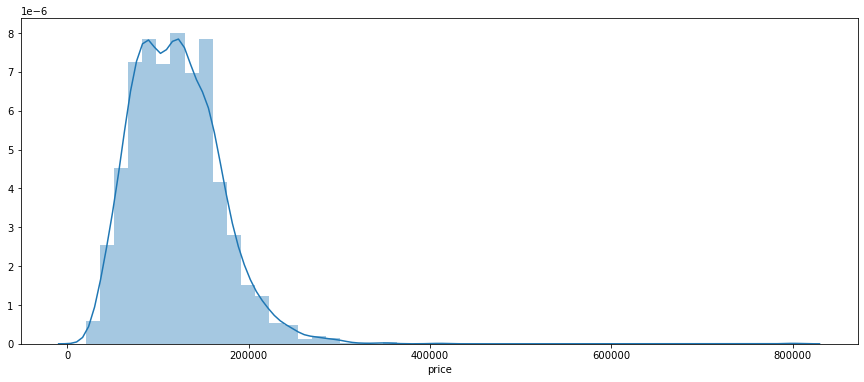

In [91]:
sb.distplot(df.price)

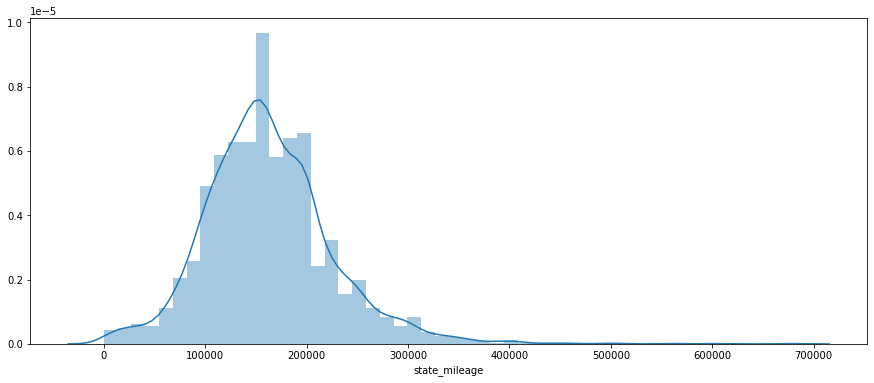

In [92]:
sb.distplot(df.state_mileage)

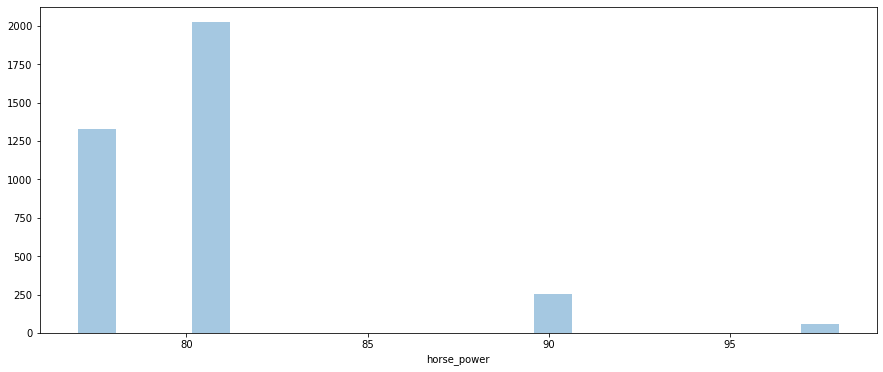

In [93]:
sb.distplot(df.horse_power, kde=False, bins=20)

In [94]:
m = folium.Map(location=[70.5236, 105.6750],
               zoom_start=3)

for i in df.index:
    folium.Circle( (df.seller_coords[i][0], df.seller_coords[i][1]), 
                  radius=70,
                  tooltip=df.price[i],
                  opacity=1,
                  fill=True,
                  
                  color=f'#{df.color_hex[i]}').add_to(m)
m

In [95]:
df.shape

(3663, 17)